# Chapter 4 - Filtering in the Frequency Domain

In [129]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2

print("NumPy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("OpenCV version:", cv2.__version__)

NumPy version: 1.26.4
Matplotlib version: 3.8.0
OpenCV version: 4.9.0


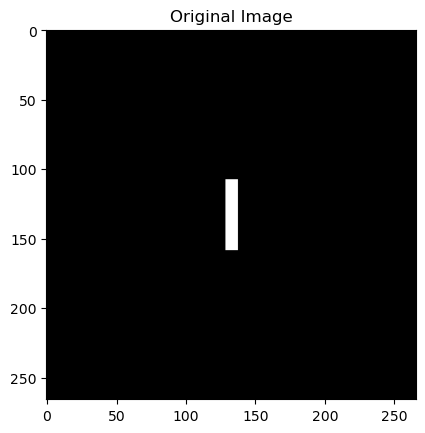

In [130]:
f_image = cv2.imread('../database/chapter_4/f_image.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(f_image, cmap='gray')
plt.title('Original Image')
plt.show()

## 4.2 - Computing and Visualizing the 2-D OFT in MATLAB

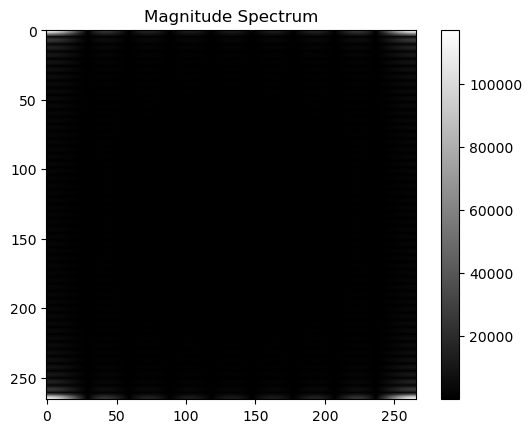

In [131]:
fourier_transform = np.fft.fft2(f_image)

magnitude_spectrum = np.abs(fourier_transform)

plt.imshow(magnitude_spectrum, cmap='gray')
plt.colorbar()
plt.title('Magnitude Spectrum')
plt.show()

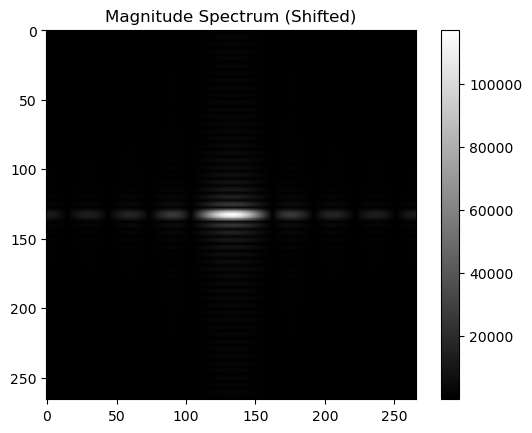

In [132]:
shifted_fourier = np.fft.fftshift(fourier_transform)

magnitude_spectrum_shifted = np.abs(shifted_fourier)

plt.imshow(magnitude_spectrum_shifted, cmap='gray')
plt.colorbar()
plt.title('Magnitude Spectrum (Shifted)')
plt.show()

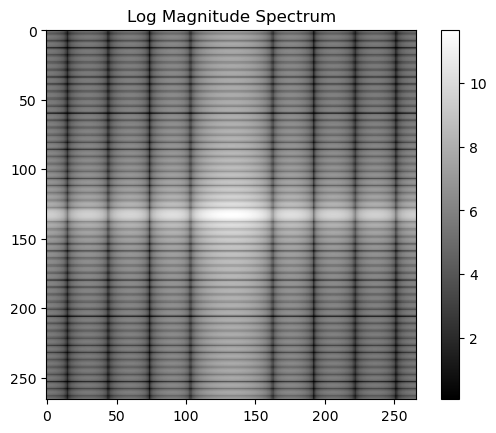

In [133]:
log_magnitude_spectrum = np.log1p(magnitude_spectrum_shifted)

plt.imshow(log_magnitude_spectrum, cmap='gray')
plt.colorbar()
plt.title('Log Magnitude Spectrum')
plt.show()

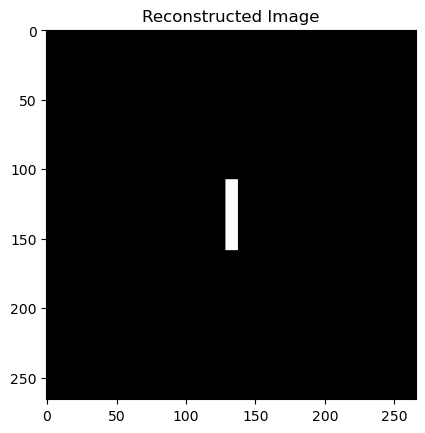

In [134]:
inverse_shifted_fourier = np.fft.ifftshift(shifted_fourier)

reconstructed_image = np.fft.ifft2(inverse_shifted_fourier)

reconstructed_image = np.abs(reconstructed_image)

plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.show()

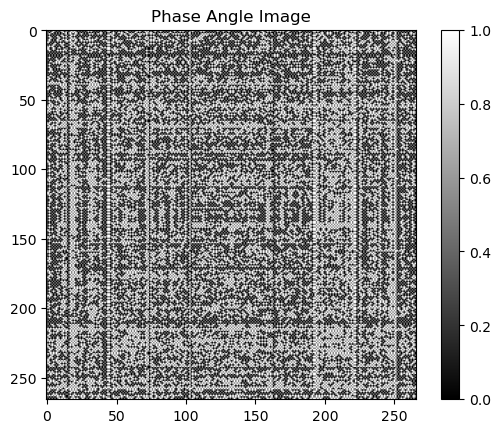

In [135]:
# Ajustar depois
phase_angle = np.angle(shifted_fourier)

phase_angle_normalized = (phase_angle + np.pi) / (2 * np.pi)

plt.imshow(phase_angle_normalized, cmap='gray')
plt.colorbar()
plt.title('Phase Angle Image')
plt.show()

## 4.3 - Filtering in the Frequency Domain
### 4.3.1 - Fundamentals

In [136]:
def paddedsize(ab, cd=None, param=None):
    if cd is None and param is None:
        pq = (2 * ab[0], 2 * ab[1])
    elif cd is not None and param is None:
        pq = (ab[0] + cd[0] - 1, ab[1] + cd[1] - 1)
        pq = (2 * int(np.ceil(pq[0] / 2)), 2 * int(np.ceil(pq[1] / 2)))
    elif cd is None and param == 'PWR2':
        m = max(ab)
        p = 2 ** np.ceil(np.log2(2 * m))
        pq = (int(p), int(p))
    elif cd is not None and param == 'PWR2':
        m = max(max(ab), max(cd))
        p = 2 ** np.ceil(np.log2(2 * m))
        pq = (int(p), int(p))
    else:
        raise ValueError('Wrong number of inputs or invalid parameter.')
    
    return pq

def lpfilter(filter_type, rows, cols, sigma):
    r, c = np.meshgrid(range(rows), range(cols), indexing='ij')
    r -= rows // 2
    c -= cols // 2
    
    if filter_type == 'gaussian':
        H = np.exp(-(r**2 + c**2) / (2 * sigma**2))
        H = np.fft.fftshift(H)
    
    return H

def tofloat(img):
    return img.astype(np.float32)

def revertclass(img, img_type):
    return img.astype(img_type)

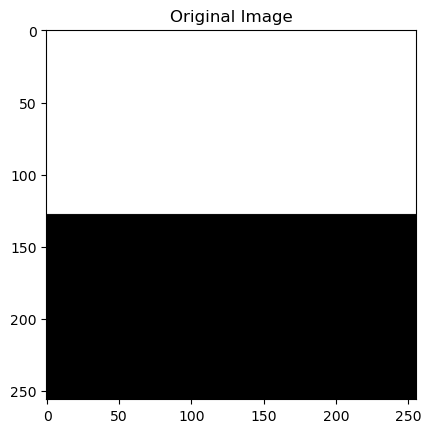

In [137]:
padding_image = cv2.imread('../database/chapter_4/p_image.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(padding_image, cmap='gray')
plt.title('Original Image')
plt.show()

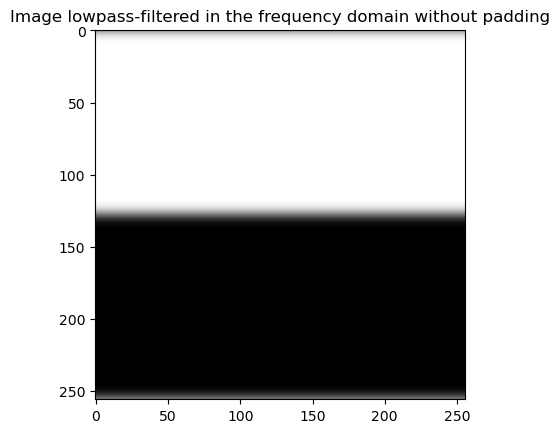

In [138]:
M, N = padding_image.shape

f = tofloat(padding_image)

F = np.fft.fft2(f)

sig = 10

H = lpfilter('gaussian', M, N, sig)

G = H * F

g = np.fft.ifft2(G).real

g = revertclass(g, f.dtype)

plt.imshow(g, cmap='gray')
plt.title("Image lowpass-filtered in the frequency domain without padding")
plt.show()

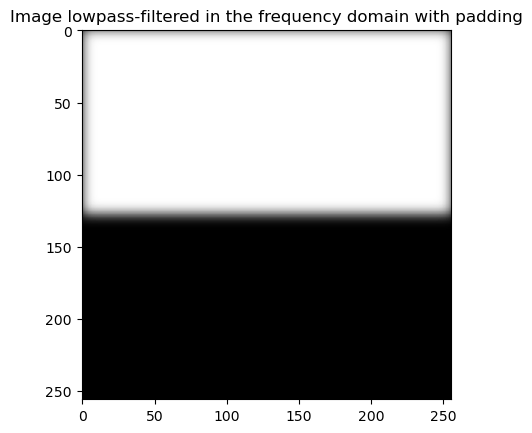

In [139]:
M, N = padding_image.shape

f = tofloat(padding_image)

PQ = paddedsize(f.shape)

Fp = np.fft.fft2(f, (PQ[0], PQ[1]))

sig = 10

Hp = lpfilter('gaussian', PQ[0], PQ[1], 2 * sig)

Gp = Hp * Fp

gp = np.fft.ifft2(Gp).real

gpc = gp[:f.shape[0], :f.shape[1]]

gpc = revertclass(gpc, f.dtype)

plt.imshow(gpc, cmap='gray')
plt.title("Image lowpass-filtered in the frequency domain with padding")
plt.show()

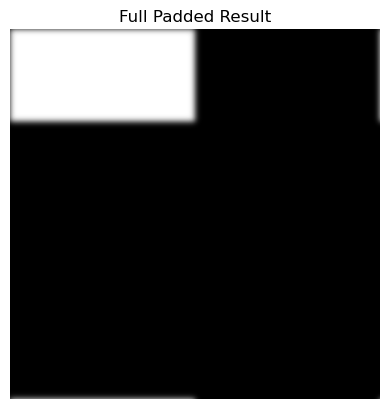

In [140]:
f = tofloat(padding_image)

Fp = np.fft.fft2(padding_image, (PQ[0], PQ[1]))

Gp = Hp * Fp

gp = np.fft.ifft2(Gp).real

plt.imshow(gp, cmap='gray')
plt.axis('off')
plt.title('Full Padded Result')
plt.show()

### 4.3.3 - An M-function for Filtering in the Frequency Domain

In [141]:
def tofloat(img):
    revertClass = lambda x: x.astype(img.dtype)
    img = img.astype(np.float32)
    return img, revertClass

def dftfilt(f, H, classout='original'):
    f, revertClass = tofloat(f)
    
    F = np.fft.fft2(f, H.shape)
    
    g = np.fft.ifft2(H * F).real
    
    g = g[:f.shape[0], :f.shape[1]]
    
    if classout == 'original':
        g = revertClass(g)
    elif classout == 'fltpoint':
        return g
    else:
        raise ValueError('Undefined class for the output image.')
    
    return g

## 4.4 - Obtaining Frequency Domain Filters from Spatial Filter

In [142]:
def freq_domain_filter(spatial_filter, shape):
    rows, cols = shape
    R, C = rows * cols, rows * cols
    spatial_filter = np.float32(spatial_filter)
    H = cv2.dft(spatial_filter, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows=R)
    return H

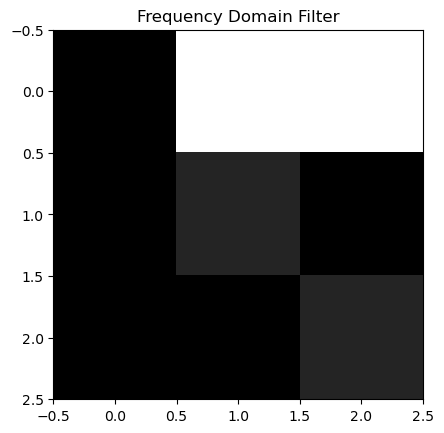

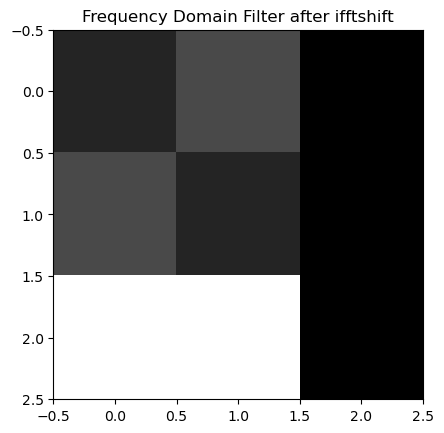

In [143]:
lena_image = cv2.imread('../database/chapter_4/lenna.png', cv2.IMREAD_GRAYSCALE)

sobel_filter = np.array([
    [2, 0, -2],
    [3, 0, -3],
    [2, 0, -2]
])

f = np.float32(lena_image)
F = np.fft.fft2(f)
S = np.fft.fftshift(np.log(1 + np.abs(F)))

H = freq_domain_filter(sobel_filter, f.shape[:2])
H1 = np.fft.ifftshift(H)

plt.figure()
plt.imshow(np.abs(H[:, :, 0]), cmap='gray')
plt.title('Frequency Domain Filter')
plt.show()

plt.figure()
plt.imshow(np.abs(H1[:, :, 0]), cmap='gray')
plt.title('Frequency Domain Filter after ifftshift')
plt.show()

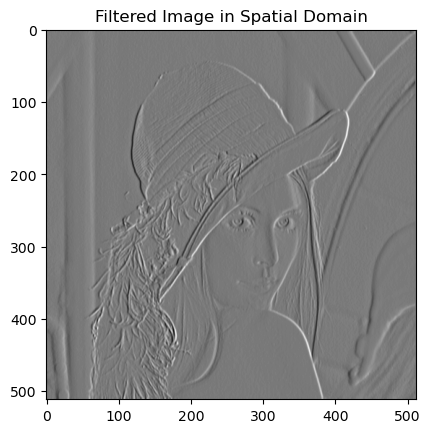

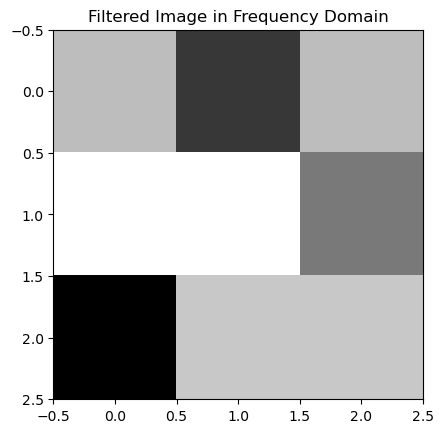

In [144]:
gs = cv2.filter2D(f, -1, sobel_filter)
gf = cv2.idft(H1, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)

plt.figure()
plt.imshow(gs, cmap='gray')
plt.title('Filtered Image in Spatial Domain')
plt.show()

plt.figure()
plt.imshow(gf, cmap='gray')
plt.title('Filtered Image in Frequency Domain')
plt.show()

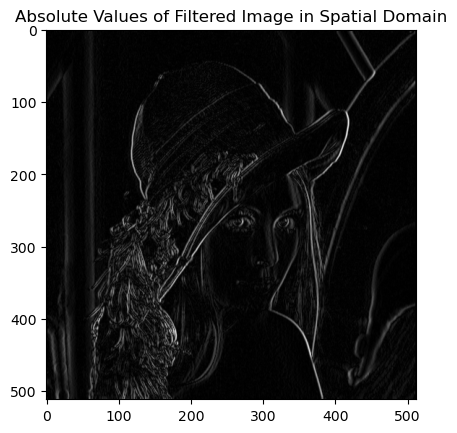

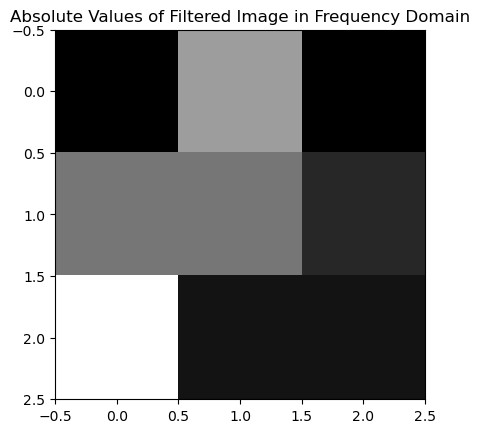

In [145]:
plt.figure()
plt.imshow(np.abs(gs), cmap='gray')
plt.title('Absolute Values of Filtered Image in Spatial Domain')
plt.show()

plt.figure()
plt.imshow(np.abs(gf), cmap='gray')
plt.title('Absolute Values of Filtered Image in Frequency Domain')
plt.show()

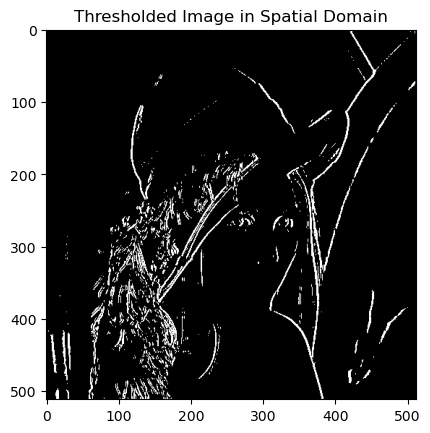

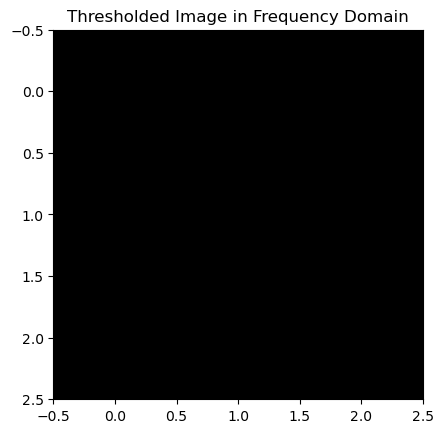

In [146]:
threshold = 0.2 * np.max(gs)
thresholded_gs = np.abs(gs) > threshold

threshold = 0.2 * np.max(gf)
thresholded_gf = np.abs(gf) > threshold

plt.figure()
plt.imshow(thresholded_gs, cmap='gray')
plt.title('Thresholded Image in Spatial Domain')
plt.show()

plt.figure()
plt.imshow(thresholded_gf, cmap='gray')
plt.title('Thresholded Image in Frequency Domain')
plt.show()

In [149]:
gf_resized = cv2.resize(gf, (lena_image.shape[1], lena_image.shape[0]))

gf_sobel = cv2.filter2D(gf_resized, -1, sobel_filter)

difference = np.abs(gs - gf_sobel)
max_diff = np.max(difference)
min_diff = np.min(difference)

print("Maximum Difference:", max_diff)
print("Minimum Difference:", min_diff)

Maximum Difference: 1141.1371
Minimum Difference: 0.0


## 4.5 - Generating Filters Directly in the Frequency Domain

In [150]:
def dftuv(M, N):
    u = np.arange(0, M, dtype=np.float32)
    v = np.arange(0, N, dtype=np.float32)
    
    idx = np.where(u > M / 2)
    u[idx] -= M
    
    idy = np.where(v > N / 2)
    v[idy] -= N
    
    V, U = np.meshgrid(v, u)
    return U, V

def lpfilter(filter_type, M, N, DO, n=1):
    U, V = dftuv(M, N)
    D = np.hypot(U, V)
    
    if filter_type == 'ideal':
        H = np.array(D <= DO, dtype=np.float32)
    elif filter_type == 'btw':
        H = 1 / (1 + (D / DO) ** (2 * n))
    elif filter_type == 'gaussian':
        H = np.exp(-(D ** 2) / (2 * (DO ** 2)))
    else:
        raise ValueError('Unknown filter type.')
    
    return H

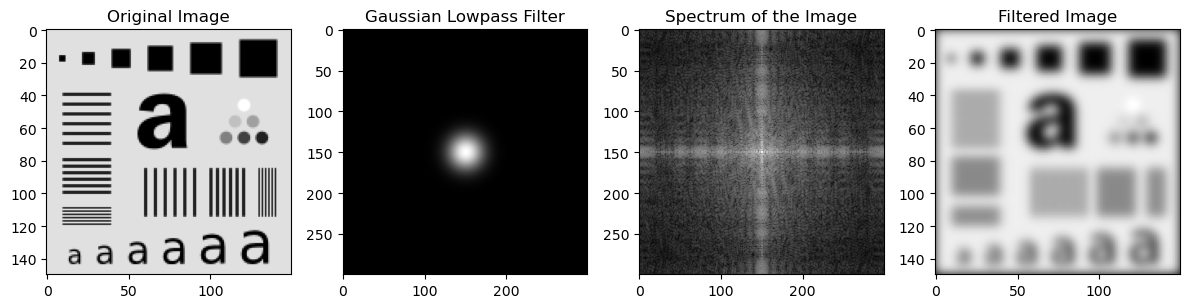

In [153]:
l_image = cv2.imread('../database/chapter_4/l_image.png', cv2.IMREAD_GRAYSCALE)
l_image = np.float32(l_image)
l_image /= 255.0

PQ = np.array(l_image.shape) * 2
U, V = dftuv(PQ[0], PQ[1])
D = np.hypot(U, V)
DO = 0.05 * PQ[1]

F = np.fft.fft2(l_image, s=PQ)
H = np.exp(-(D ** 2) / (2 * (DO ** 2)))
G = F * H
g = np.real(np.fft.ifft2(G))

g = g[:l_image.shape[0], :l_image.shape[1]]

plt.figure(figsize=(12, 5))

plt.subplot(1, 4, 1)
plt.imshow(l_image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 4, 2)
plt.imshow(np.fft.fftshift(H), cmap='gray')
plt.title("Gaussian Lowpass Filter")

spectrum = np.fft.fftshift(np.log(1 + np.abs(F)))
plt.subplot(1, 4, 3)
plt.imshow(spectrum, cmap='gray')
plt.title("Spectrum of the Image")

plt.subplot(1, 4, 4)
plt.imshow(g, cmap='gray')
plt.title("Filtered Image")

plt.tight_layout()
plt.show()

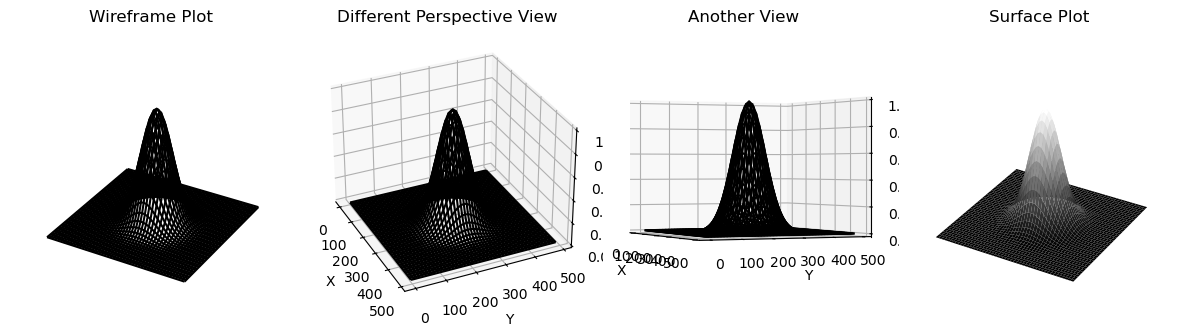

In [154]:
H = lpfilter('gaussian', 500, 500, 50)
H = np.fft.fftshift(H)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(141, projection='3d')
k = 10
X, Y = np.meshgrid(np.arange(0, H.shape[1], k), np.arange(0, H.shape[0], k))
ax1.plot_wireframe(X, Y, H[::k, ::k], color='black')
ax1.set_title('Wireframe Plot')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Amplitude')

ax1.grid(False)
ax1.axis('off')

ax2 = fig.add_subplot(142, projection='3d')
ax2.plot_wireframe(X, Y, H[::k, ::k], color='black')
ax2.view_init(azim=-25, elev=30)
ax2.set_title('Different Perspective View')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Amplitude')

ax3 = fig.add_subplot(143, projection='3d')
ax3.plot_wireframe(X, Y, H[::k, ::k], color='black')
ax3.view_init(azim=-25, elev=0)
ax3.set_title('Another View')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Amplitude')

ax4 = fig.add_subplot(144, projection='3d')
ax4.plot_surface(X, Y, H[::k, ::k], cmap='gray', linewidth=0)
ax4.set_title('Surface Plot')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Amplitude')

ax4.grid(False)
ax4.axis('off')

plt.tight_layout()
plt.show()

# 4.6 - Highpass (Sharpening) Frequency Domain Filters 

In [155]:
def hpfilter(filter_type, M, N, DO, n=1):
    Hlp = lpfilter(filter_type, M, N, DO, n)
    H = 1 - Hlp
    return H

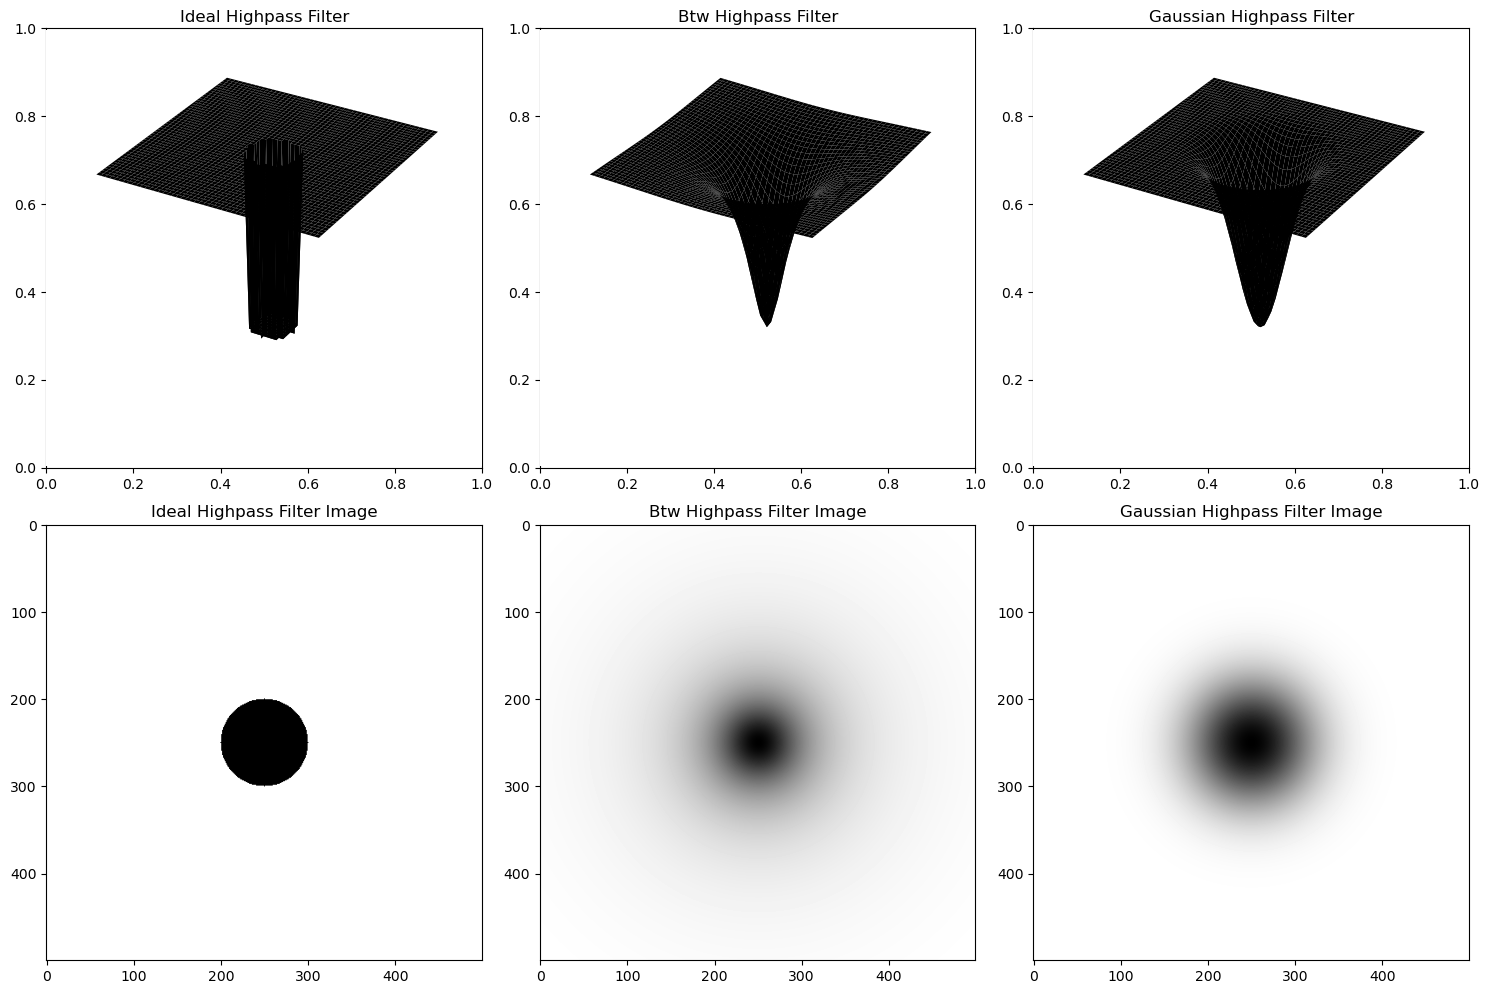

In [162]:
from mpl_toolkits.mplot3d import Axes3D

# Gaussian Highpass Filter (Example 4.7)
H_hp = hpfilter('gaussian', 500, 500, 50)
H_hp = np.fft.fftshift(H_hp)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

k = 10 
X, Y = np.meshgrid(np.arange(0, H_hp.shape[1], k), np.arange(0, H_hp.shape[0], k))

for i, filter_type in enumerate(['ideal', 'btw', 'gaussian']):
    H_hp = hpfilter(filter_type, 500, 500, 50)
    H_hp = np.fft.fftshift(H_hp)
    
    ax = axs[0, i]
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.plot_surface(X, Y, H_hp[::k, ::k], color='black')
    ax.set_title(f'{filter_type.capitalize()} Highpass Filter')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Amplitude')
    ax.grid(False)
    ax.axis('off')

    ax_img = axs[1, i]
    ax_img.imshow(H_hp, cmap='gray')
    ax_img.set_title(f'{filter_type.capitalize()} Highpass Filter Image')

plt.tight_layout()
plt.show()

### 4.6.2 High-Frequency Emphasis Filtering 

In [163]:
def high_frequency_emphasis_filter(image, a, h, DO, filter_type='btw', n=2):
    H_hp = hpfilter(filter_type, image.shape[0], image.shape[1], DO, n)
    H_hp = a + h * H_hp

    G_hp = np.fft.fft2(image)
    G_hp = np.fft.fftshift(G_hp)
    G_hp = H_hp * G_hp
    G_hp = np.fft.ifftshift(G_hp)
    g_hp = np.fft.ifft2(G_hp)
    g_hp = np.abs(g_hp)
    g_hp = g_hp / np.max(g_hp) * 255

    return g_hp.astype(np.uint8)

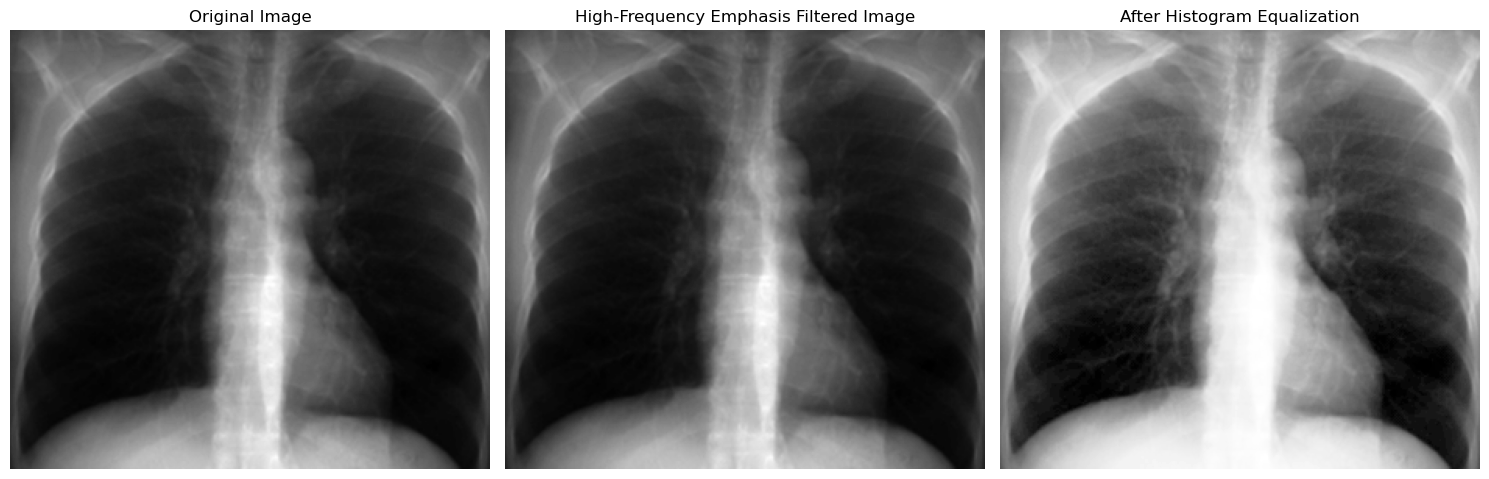

In [166]:
xray_chest = cv2.imread('../database/chapter_4/xray_chest.png', cv2.IMREAD_GRAYSCALE)

a = 0.5
h = 2.0
DO = 0.05 * xray_chest.shape[0]
filtered_image = high_frequency_emphasis_filter(xray_chest, a, h, DO)

equalized_image = cv2.equalizeHist(filtered_image)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(xray_chest, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(filtered_image, cmap='gray')
axs[1].set_title('High-Frequency Emphasis Filtered Image')
axs[1].axis('off')

axs[2].imshow(equalized_image, cmap='gray')
axs[2].set_title('After Histogram Equalization')
axs[2].axis('off')

plt.tight_layout()
plt.show()

## 4.7 - Selective Filtering
### 4.7.1 - Bandreject and Bandpass Filters 

In [204]:
from scipy.spatial.distance import cdist

def dftuv(M, N):
    u = np.arange(0, M, dtype=np.float32)
    v = np.arange(0, N, dtype=np.float32)
    
    idx = np.where(u > M / 2)
    u[idx] -= M
    
    idy = np.where(v > N / 2)
    v[idy] -= N
    
    V, U = np.meshgrid(v, u)
    return U, V

def bandfilter(type, band, M, N, DO, W, n=1):
    u = np.arange(-M//2, M//2)
    v = np.arange(-N//2, N//2)
    V, U = np.meshgrid(v, u)
    
    D = np.sqrt(U**2 + V**2)
    
    if n is None:
        n = 1
    
    if type.lower() == 'ideal':
        H = idealReject(D, DO, W)
    elif type.lower() == 'btw':
        H = btwReject(D, DO, W, n)
    elif type.lower() == 'gaussian':
        H = gaussReject(D, DO, W)
    else:
        raise ValueError('Unknown filter type.')
    
    if band.lower() == 'pass':
        H = 1 - H
    
    return H

def idealReject(D, DO, W):
    RI = (D >= DO - (W/2)) & (D <= DO + (W/2))
    return np.float32(~RI)

def btwReject(D, DO, W, n):
    H = 1 / (1 + (((D * W) / (D**2 - DO**2)) ** (2 * n)))
    return np.float32(H)

def gaussReject(D, DO, W):
    H = 1 - np.exp(-(((D**2 - DO**2) / (D * W + np.finfo(float).eps)) ** 2))
    return np.float32(H)

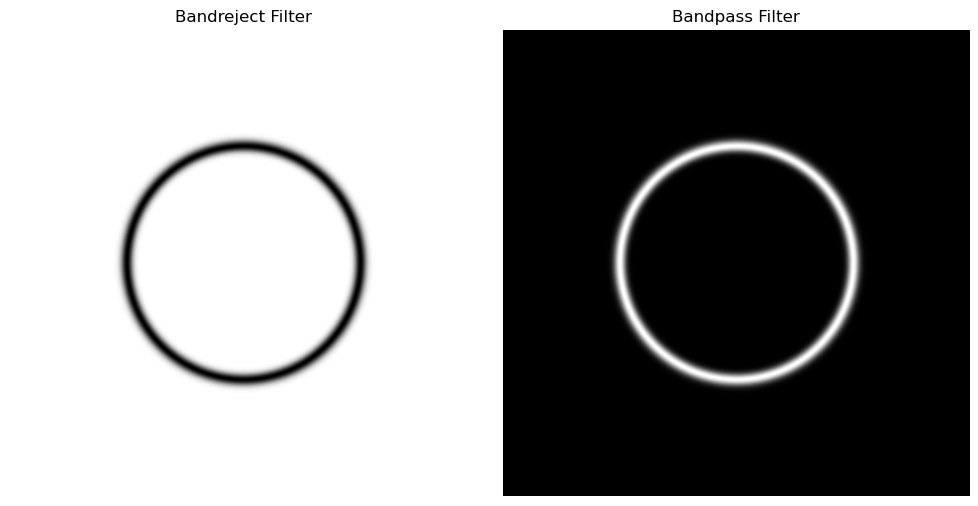

In [205]:
# Parameters
M = 800
N = 800
DO = 200
W = 20
n = 1

H_reject = bandfilter('gaussian', 'reject', M, N, DO, W)

H_pass = bandfilter('gaussian', 'pass', M, N, DO, W)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(H_reject, cmap='gray')
axs[0].set_title('Bandreject Filter')
axs[0].axis('off')

axs[1].imshow(H_pass, cmap='gray')
axs[1].set_title('Bandpass Filter')
axs[1].axis('off')

plt.tight_layout()
plt.show()